# **Fine-Tune ViT for Image Classification with Hugging Face Transformers**


The Vision Transformer (ViT) is a deep learning model that adapts the Transformer architecture, originally developed for NLP, to handle image data. ViT splits an image into fixed-size patches, linearly embeds them, and processes them as a sequence of tokens similar to words in text. It captures long-range dependencies and global context effectively, often outperforming convolutional neural networks (CNNs) in various vision tasks when pre-trained on large datasets. ViT models are particularly known for their scalability and high accuracy in image classification.

Reference : https://huggingface.co/blog/fine-tune-vit

## Load dataset

In [1]:
!pip install evaluate -q

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [3]:
#load dataset
ds= load_dataset('/kaggle/input/asl-sign-language-hand-landmarks-with-images/ASL-aplhabet-dataset-with_Hand landmark')
ds

Resolving data files:   0%|          | 0/33771 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1695 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 33771
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1695
    })
})

In [4]:
#sample
print("dataset features :" ,ds["train"].features)
print("sample :",ds["train"][25])

dataset features : {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], id=None)}
sample : {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x7ADED86EA890>, 'label': 0}


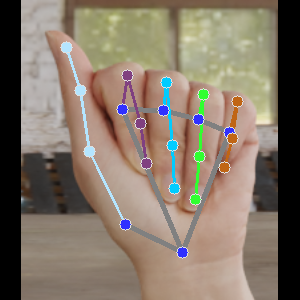

In [5]:
#show image 
image=ds["train"][25]["image"]
image

### **Visual samples**

In [6]:
"""
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0,50), examples_per_class=3)"""

'\nfrom transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor\nimport random\nfrom PIL import ImageDraw, ImageFont, Image\n\ndef show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):\n\n    w, h = size\n    labels = ds[\'train\'].features[\'label\'].names\n    grid = Image.new(\'RGB\', size=(examples_per_class * w, len(labels) * h))\n    draw = ImageDraw.Draw(grid)\n    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)\n\n    for label_id, label in enumerate(labels):\n\n        # Filter the dataset by a single label, shuffle it, and grab a few samples\n        ds_slice = ds[\'train\'].filter(lambda ex: ex[\'label\'] == label_id).shuffle(seed).select(range(examples_per_class))\n\n        # Plot this label\'s examples along a row\n        for i, example in enumerate(ds_slice):\n            image = example[\'image\']\n            idx = examples_per_class * label_id + i\n            box = (idx % exam

## Loading ViT Feature Extractor

In [7]:
from transformers import ViTFeatureExtractor,ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k' #"google/vit-base-patch32-384"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
print("feature_extractor :",feature_extractor)

print("processor :",processor)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

feature_extractor : ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

processor : ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

## Processing the Dataset

**Example**

In [9]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [10]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'labels': 0}

transform the ladaset

In [11]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs



In [12]:
# split up training into training + validation
splits = ds["train"].train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']

In [13]:
pre_train_ds = train_ds.with_transform(transform)
print("prepared_ds shape :", pre_train_ds.shape)
pre_val_ds = val_ds.with_transform(transform)
print("prepared_ds shape :", pre_val_ds.shape)

prepared_ds shape : (28705, 2)
prepared_ds shape : (5066, 2)


In [14]:
#sample
print(pre_train_ds[12:16])

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1

## Training and Evaluation

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [15]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [16]:
#Not mandatory
#from transformers import DefaultDataCollator
#collate_fn = DefaultDataCollator(return_tensors="pt")

### Define an evaluation metric

In [17]:
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

label to Id

In [18]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
    
print("lebel2id :",label2id)
print("id2label :",id2label)

lebel2id : {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'DEL': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'SPACE': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}
id2label : {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'DEL', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'SPACE', 21: 'T', 22: 'U', 23: 'V', 24: 'W', 25: 'X', 26: 'Y', 27: 'Z'}


Load pretrain model

In [19]:
from transformers import ViTForImageClassification



model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


set training argument

In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-ASL_v1",
  per_device_train_batch_size=96,
  eval_strategy="steps",
  num_train_epochs=3,
  fp16=True,
  save_steps=50,
  eval_steps=25,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

### Training the model

In [21]:
from torch.amp import GradScaler

scaler = GradScaler(device='cuda')


In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=pre_train_ds,
    eval_dataset=pre_val_ds,
    tokenizer=feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [23]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
25,2.412600,1.770896,0.849585
50,0.980700,0.811802,0.966246
75,0.547100,0.420701,0.982432
100,0.276800,0.265151,0.982037
125,0.199400,0.179232,0.986972
150,0.148400,0.137876,0.989538
175,0.111000,0.103965,0.992696
200,0.074300,0.114912,0.981642
225,0.064200,0.090920,0.985393
250,0.049600,0.058458,0.992499


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

***** train metrics *****
  epoch                    =          3.0
  total_flos               = 6216371194GF
  train_loss               =        0.314
  train_runtime            =   0:59:43.56
  train_samples_per_second =       24.031
  train_steps_per_second   =        0.126


### Evaluatiuon

In [24]:
#test_ds = load_dataset('/kaggle/input/glasses-classification-dataset/validate')
#test_ds

In [25]:
pre_test_ds = ds["test"].with_transform(transform)
print("prepared_ds shape :", pre_test_ds.shape)

prepared_ds shape : (1695, 2)


In [26]:
pre_test_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], id=None)}

In [27]:
metrics = trainer.evaluate(pre_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9971
  eval_loss               =     0.0154
  eval_runtime            = 0:00:36.99
  eval_samples_per_second =     45.815
  eval_steps_per_second   =      2.865


### Confusion Matrix

In [28]:
from transformers import ViTForImageClassification  # or the appropriate model class

# Load the model from the output directory
model_train = ViTForImageClassification.from_pretrained("/kaggle/working/vit-base-ASL_v1")
model_train.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        35
           B       1.00      1.00      1.00        79
           C       1.00      1.00      1.00        64
           D       1.00      1.00      1.00        68
         DEL       1.00      1.00      1.00        22
           E       1.00      0.97      0.98        58
           F       1.00      1.00      1.00        86
           G       1.00      1.00      1.00        86
           H       1.00      1.00      1.00        90
           I       1.00      1.00      1.00        66
           J       1.00      1.00      1.00        67
           K       1.00      1.00      1.00        88
           L       1.00      0.99      0.99        87
           M       0.95      1.00      0.97        35
           N       1.00      1.00      1.00        62
           O       1.00      1.00      1.00        39
           P       1.00      1.00      1.00        57
           Q       1.00    

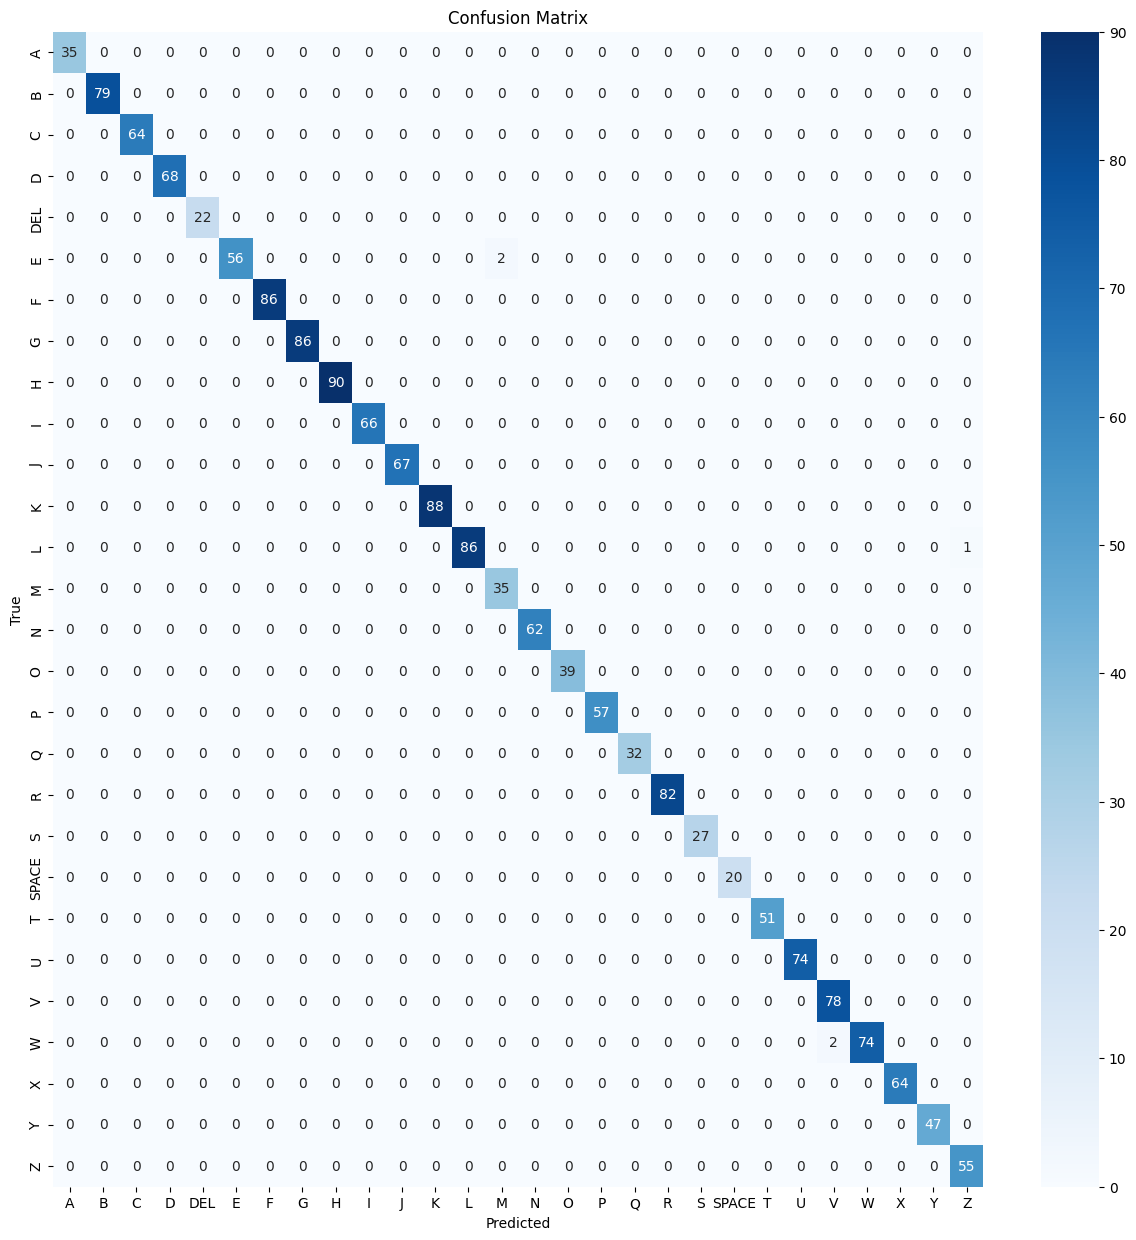

Real labels : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(model,ds,label_list):
    Real_labels=[]
    predict_label=[]

    for img,label in zip (ds["test"]["image"],ds["test"]["label"]):
        
        img=feature_extractor(img, return_tensors='pt')
        # Get predictions
        with torch.no_grad():
            outputs = model(**img)
            #print(outputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
        predict_label.append(predictions.item())
        #print(predictions.item())
        Real_labels.append(label)
        #print(label)


    # Generate classification report
    report = classification_report(Real_labels,predict_label, target_names=label_list)
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(Real_labels,predict_label)

    # Plot confusion matrix
    plt.figure(figsize=(15,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return Real_labels,predict_label


label_list=ds["test"].features["label"].names

Real_labels,predict_label=evaluation(model_train,ds,label_list)

print("Real labels :",Real_labels)
print("predict labels :",predict_label)

## Inferences

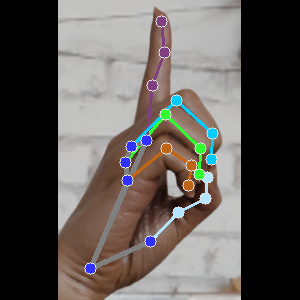

Predicted class: D


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [30]:
import torch
from PIL import Image
from IPython.display import display
from transformers import AutoFeatureExtractor

# Load an image and feature extractor (preprocessing for vision models)
image = Image.open("/kaggle/input/asl-sign-language-hand-landmarks-with-images/ASL-aplhabet-dataset-with_Hand landmark/test/D/31e32fe1-a28c-4fa4-a799-add1e643171b.rgb_0000.png")
# Display the image
display(image)


feature_extractor = AutoFeatureExtractor.from_pretrained("/kaggle/working/vit-base-ASL_v1")

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Get predictions
with torch.no_grad():
    outputs = model_train(**inputs)
    #print(outputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

print(f"Predicted class: {id2label[predictions.item()]}")


### Before getting predictions of this model, do the mentioned steps.

1. Detect the hand 
1. Crop the detected hand 
1. Mark the hand landmarks use mediapipe 
1. Get model predictions

Refference : 

### ********Below prediction get only visualization purpose*****

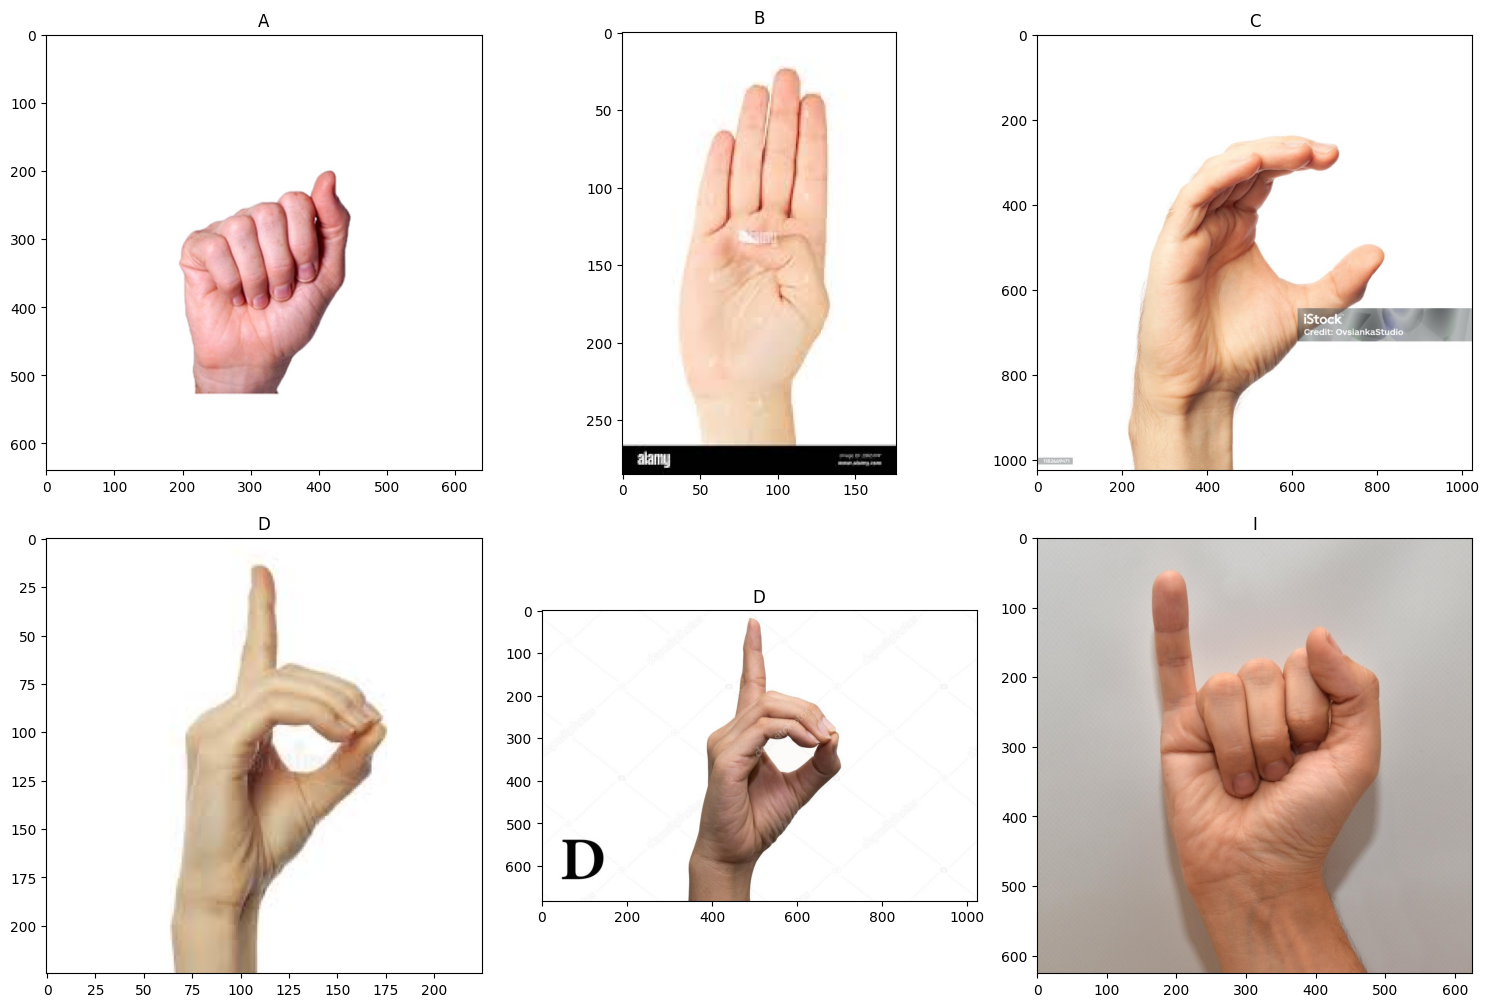

In [31]:
import cv2
import requests

# URLs to images
urls = [
    "https://emilypost.com/client_media/images/a.jpg","https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmQCKtCjxg5C2Dl9KnsKox0GztSLe84uoOew&s",
    "https://media.istockphoto.com/id/1182669471/photo/finger-spelling-letter-c-in-asl-on-white-background-american-sign-language-concept.jpg?s=1024x1024&w=is&k=20&c=iBDQ1kfsl-sP3WkoWmLBANE4tRFM82aTLTPYcFkZORs=",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRCi8UHM-Arf0GjI96u_QdMmk-_e-4tbnpygA&s",
    "https://st2.depositphotos.com/3793765/6411/i/950/depositphotos_64115645-stock-photo-finger-spelling-the-alphabet-in.jpg",
    "https://img.freepik.com/premium-photo/letter-i-american-sign-language-asl_568886-874.jpg",
]

feature_extractor = AutoFeatureExtractor.from_pretrained("/kaggle/working/vit-base-ASL_v1")

fig = plt.figure(figsize = (15, 15))

for i, url in enumerate(urls):
    plt.subplot(331 + i)

    # Sending request to the URL
    r = requests.get(url, stream = True).raw

    # Reading image, convert it to np array and decode
    image = np.asarray(bytearray(r.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # Preprocess the image
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Get predictions
    with torch.no_grad():
        outputs = model_train(**inputs)
        #print(outputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
    predict_label=id2label[predictions.item()]
    #print(f"Predicted class: {predict_label}")


    # Showing image
    plt.imshow(image[:, :, ::-1])
    plt.title(f'{predict_label}')

plt.tight_layout()